In [2]:
import pandas as pd
import numpy as np
import os
import sys
import fcLib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import yearly load and outside temperature data from GridWorks
df = pd.read_excel(os.getcwd()+'/data/gridworks_yearly_data.xlsx', header=3, index_col = 0)
df.index = pd.to_datetime(df.index)
df.index.name = None

# Rename columns
renamed_columns = {
    'Outside Temp F': 'T_OA',
    'House Power Required AvgKw': 'Q_load'}
df.rename(columns=renamed_columns, inplace=True)

# Convert outside air temperature from °F to °C
df['T_OA'] = df['T_OA'].apply(lambda x: round(5/9 * (x-32),2))

# Keep only date, weather, and load
df = df[['T_OA','Q_load']]#[:1000]

df.head()

,T_OA,Q_load
2022-01-01 00:00:00,-3.89,5.91
2022-01-01 01:00:00,-3.33,5.77
2022-01-01 02:00:00,-2.78,5.67
2022-01-01 03:00:00,-3.33,5.77
2022-01-01 04:00:00,-3.33,5.71


Correlation between outside temperature and load: -0.99, p-value: 0.0


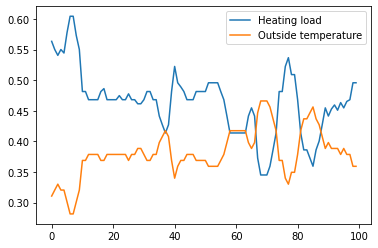

In [3]:
from scipy import stats
correlation, p_value = stats.spearmanr(df.T_OA, df.Q_load)
print(f"Correlation between outside temperature and load: {round(correlation,2)}, p-value: {p_value}")

# Scale the load and outside temperature for the plot
df['Q_load_scaled'] = (df['Q_load'] - df['Q_load'].min()) / (df['Q_load'].max() - df['Q_load'].min())
df['T_OA_scaled'] = (df['T_OA'] - df['T_OA'].min()) / (df['T_OA'].max() - df['T_OA'].min())

# Plot the load and outside temperature 
plt.plot(df.Q_load_scaled[0:100].tolist(), label="Heating load")
plt.plot(df.T_OA_scaled[0:100].tolist(), label="Outside temperature")
plt.legend()
plt.show()

df = df.drop('Q_load_scaled', axis=1)
df = df.drop('T_OA_scaled', axis=1)

In [4]:
# Split the data into X (weather) and y (load)
X_columns = [col for col in df.columns if not 'Q_load' in col]
y_columns = [col for col in df.columns if 'Q_load' in col]
X = df[X_columns]
y = df[y_columns]

# Create training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42)

print("X columns: ", X_columns)
print("y columns: ", y_columns)

X columns:  ['T_OA']
y columns:  ['Q_load']


In [5]:
# Create a dataframe to store the RMSE of each forecaster on the testing data
library = fcLib.forecasters(fcLib.forecaster_list)
forecaster_names = [forecaster['name'] for forecaster in library.forecasters]
forecaster_names.remove('todt')
forecaster_names.remove('sarimax_with_forecast')
scores = pd.DataFrame(index = forecaster_names, columns = ['RMSE'])

# Create a dict to store prediction values for a 48-hour plot
data_plots = {}

# Iterate through each of the models
for forecaster in library.forecasters:

    #print(forecaster['name'])
    if forecaster['name'] == 'todt': continue
    if forecaster['name'] == 'sarimax_with_forecast': continue
    data_plots[f"{forecaster['name']}"] = []

    # Fit the model to the training data and predict for the testing data
    model = getattr(fcLib, forecaster['fun'])(**forecaster['parameter'])
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    # Calculate the rmse and store it in the associated dataframe
    rmse = np.sqrt(mean_squared_error(y_test, predict))
    scores.loc[forecaster['name'], 'RMSE'] = rmse

    # For 48-hour plot
    for i in range(48):    
        forecast = [[X.T_OA[i].tolist()]]
        predict = model.predict(forecast)

        if forecaster['name'] == 'gradient_boosting': 
            data_plots[f"{forecaster['name']}"].append(predict[0])
        else:
            data_plots[f"{forecaster['name']}"].append(predict)

display(scores)

,RMSE
extra_trees_pipeline,0.198889
random_forest_pipeline,0.190176
multi_layer_perceptron,0.194976
tuned_mlp,0.193406
tuned_Total_mlp,0.21032
tuned_Fast_mlp,0.193287
random_forest,0.189854
extra_trees,0.189839
gradient_boosting,0.189886


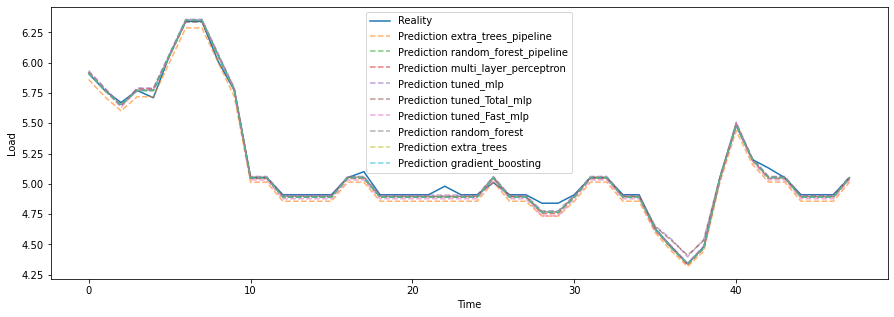

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df.Q_load[0:48].tolist(), label="Reality")
for forecaster in library.forecasters:
    if forecaster['name'] == 'todt': continue
    if forecaster['name'] == 'sarimax_with_forecast': continue
    plt.plot(data_plots[f"{forecaster['name']}"], label=f"Prediction {forecaster['name']}", alpha=0.6, linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.show()

In [7]:
# ---------------------------------------------------------------------
# Now include the confidence intervals using split conformal prediction
# ---------------------------------------------------------------------

# Seperate the features X (weather) and the variable y (load)
X = df[['T_OA']]
y = df[['Q_load']]

# Split the data into training and holdout sets of same size (8760/2 = 4380)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size = 0.5, random_state = 42)
n = len(X_holdout)
print(f"n = {len(X_holdout)}")

# Train the model with the training set
for forecaster in library.forecasters:

    # Use random forest
    if forecaster['name'] != 'multi_layer_perceptron': continue

    # Fit the model to the training data
    model = getattr(fcLib, forecaster['fun'])(**forecaster['parameter'])
    model.fit(X_train, y_train)
    
    # Use the holdout data to test the model and get residuals R_1,..., R_n
    trues, predicts, residuals = [], [], []
    percentage_list = [25, 50, 75]
    print("Computing residuals...")
    for i in range(len(X_holdout)):
        predict = model.predict([[X_holdout.T_OA[i].tolist()]])[0]
        true = y_holdout.Q_load.iloc[i]
        residual = np.abs(true-predict)
        trues.append(true)
        predicts.append(predict)
        residuals.append(residual)
        if int(i/n*100) in percentage_list: 
            print(f"... {round(i/n*100)}%")
            percentage_list = percentage_list[1:] if len(percentage_list)>1 else []
    print("Done.\n")

    # Sort the residuals
    residuals.sort(reverse=False)
    
    # Get the confidence interval for a new point
    new_point = [[5]]
    predict = model.predict(new_point)[0]
    alpha = 0.1
    CI_min = predict - residuals[int((1-alpha)*(n+1))-1]
    CI_max = predict + residuals[int((1-alpha)*(n+1))-1]
    print(f"The width of the CI = {round(residuals[int((1-alpha)*(n+1))-1]*2,4)}")
    print(f"The {round((1-alpha)*100,3)}% confidence interval of the prediction is: [{round(CI_min,4)}, {round(CI_max,4)}]")

n = 4380
Computing residuals...
... 25%
... 50%
... 75%
Done.

The width of the CI = 0.5587
The 90.0% confidence interval of the prediction is: [3.2751, 3.8338]


In [8]:
print([round(x,2) for x in residuals])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

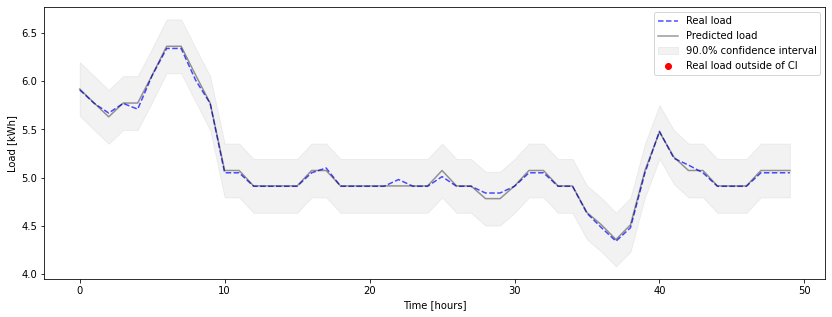

0 loads (0.0%) are outside of the predicted 90.0% confidence interval


In [9]:
plot_length = 50

plt.figure(figsize=(14,5))

for delta in [0.1]:

    predicted = []
    upper_bounds = []
    lower_bounds = []
    errors_index = [np.nan]*plot_length
    errors_count = 0

    #print(f"delta = {delta}, residual = {int((1-delta)*(n+1))-1}")
    
    for i in range(plot_length):    
        forecast = [[df.T_OA[i].tolist()]]
        
        predict = model.predict(forecast)[0]
        CI_min = predict - residuals[int((1-delta)*(n+1))-1]
        CI_max = predict + residuals[int((1-delta)*(n+1))-1]
        
        predicted.append(predict)
        lower_bounds.append(CI_min)
        upper_bounds.append(CI_max)

        if df.Q_load.iloc[i] > CI_max or df.Q_load.iloc[i] < CI_min:
            errors_index[i] = df.Q_load.iloc[i]
            errors_count += 1

    plt.plot(df.Q_load[0:plot_length].tolist(), color='blue', alpha=0.7, label="Real load", linestyle='dashed')  
    plt.plot(predicted, color='black', alpha=0.4, label='Predicted load')
    plt.fill_between(range(plot_length), lower_bounds, upper_bounds, color='gray', alpha=0.1, label=f'{round((1-delta)*100,1)}% confidence interval')
    plt.scatter(range(plot_length), errors_index, marker='o', color='red', label='Real load outside of CI')

plt.xlabel("Time [hours]")
plt.ylabel("Load [kWh]")
plt.legend()
plt.show()

print(f"{errors_count} loads ({round(errors_count/plot_length*100,2)}%) are outside of the predicted {round((1-delta)*100,1)}% confidence interval")

In [10]:
#warnings.resetwarnings()
#library.tune_hyperparameters(X, y, method = 'grid_small', cv = 4, n_forecasters = 5, n_jobs = 4)

In [11]:
#for i in library.tuned_forecasters: display(i)

In [12]:
'''
# Create a dict to store prediction values for a 48-hour plot
data_plots = {}

# Iterate through each of the models
for forecaster in library.tuned_forecasters:

    #print(forecaster['name'])
    if forecaster['name'] == 'todt': continue
    if forecaster['name'] == 'sarimax_with_forecast': continue
    data_plots[f"{forecaster['name']}"] = []

    # Fit the model to the training data and predict for the testing data
    model = getattr(fcLib, forecaster['fun'])(**forecaster['parameter'])
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    
    # Calculate the rmse and store it in the associated dataframe
    rmse = np.sqrt(mean_squared_error(y_test, predict))
    scores.loc[forecaster['name'], 'RMSE'] = rmse

    # For 48-hour plot
    for i in range(48):    
        forecast = [[X.T_OA[i].tolist()]]
        predict = model.predict(forecast)

        if forecaster['name'] == 'gradient_boosting': 
            data_plots[f"{forecaster['name']}"].append(predict[0])
        else:
            data_plots[f"{forecaster['name']}"].append(predict)

display(scores)
'''

'\n# Create a dict to store prediction values for a 48-hour plot\ndata_plots = {}\n\n# Iterate through each of the models\nfor forecaster in library.tuned_forecasters:\n\n    #print(forecaster[\'name\'])\n    if forecaster[\'name\'] == \'todt\': continue\n    if forecaster[\'name\'] == \'sarimax_with_forecast\': continue\n    data_plots[f"{forecaster[\'name\']}"] = []\n\n    # Fit the model to the training data and predict for the testing data\n    model = getattr(fcLib, forecaster[\'fun\'])(**forecaster[\'parameter\'])\n    model.fit(X_train, y_train)\n    predict = model.predict(X_test)\n    \n    # Calculate the rmse and store it in the associated dataframe\n    rmse = np.sqrt(mean_squared_error(y_test, predict))\n    scores.loc[forecaster[\'name\'], \'RMSE\'] = rmse\n\n    # For 48-hour plot\n    for i in range(48):    \n        forecast = [[X.T_OA[i].tolist()]]\n        predict = model.predict(forecast)\n\n        if forecaster[\'name\'] == \'gradient_boosting\': \n            dat

In [13]:
'''
plt.figure(figsize=(15,5))
plt.plot(df.Q_load[0:48].tolist(), label="Reality")
for forecaster in library.tuned_forecasters:
    if forecaster['name'] == 'todt': continue
    if forecaster['name'] == 'sarimax_with_forecast': continue
    plt.plot(data_plots[f"{forecaster['name']}"], label=f"Prediction {forecaster['name']}", alpha=0.6, linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(15,5))\nplt.plot(df.Q_load[0:48].tolist(), label="Reality")\nfor forecaster in library.tuned_forecasters:\n    if forecaster[\'name\'] == \'todt\': continue\n    if forecaster[\'name\'] == \'sarimax_with_forecast\': continue\n    plt.plot(data_plots[f"{forecaster[\'name\']}"], label=f"Prediction {forecaster[\'name\']}", alpha=0.6, linestyle=\'dashed\')\nplt.xlabel("Time")\nplt.ylabel("Load")\nplt.legend()\nplt.show()\n'